In [3]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import os
import io
import struct
import math

In [4]:
import idx2numpy  # For loading IDX-format MNIST data
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from tqdm import trange  # Progress bar for iterations
from sklearn.mixture import GaussianMixture  # Benchmark/comparison model

In [5]:
# Set your MNIST directory
mnist_path = "/Users/shawheennaderi/Downloads/MNIST"

# Show file list to confirm visibility
print(os.listdir(mnist_path))


['t10k-images-idx3-ubyte', 'train-labels.idx1-ubyte', 'train-images.idx3-ubyte', 't10k-labels-idx1-ubyte', 'train-images-idx3-ubyte', 't10k-labels.idx1-ubyte', 't10k-images.idx3-ubyte', 'train-labels-idx1-ubyte']


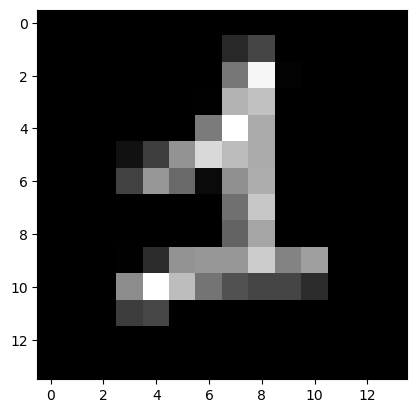

In [6]:
# -----------------------------------------------------------------------------
# 1. Data Loading & Preprocessing
# -----------------------------------------------------------------------------
# Load original MNIST images and labels
# Load original MNIST images and labels
images_ori = idx2numpy.convert_from_file(os.path.join(mnist_path, 'train-images.idx3-ubyte'))
labels_ori = idx2numpy.convert_from_file(os.path.join(mnist_path, 'train-labels.idx1-ubyte'))

# Filter to only digits 0-4 for a 5-class problem
images = images_ori[labels_ori < 5]
labels = labels_ori[labels_ori < 5]


# Perform 2×2 average pooling to reduce 28×28 -> 14×14
n_samples = images.shape[0]
images_simple = np.zeros((n_samples, 14, 14))
for i in range(14):
    for j in range(14):
        # Average the 4 pixels in each non-overlapping block
        block = images[:, 2*i:2*i+2, 2*j:2*j+2]
        images_simple[:, i, j] = block.mean(axis=(1, 2))

# Optional: display a sample image to verify pooling

plt.imshow(images_simple[15], cmap='gray')
#plt.savefig('fig1.png', bbox_inches='tight')
plt.show()

# Flatten pooled images into feature vectors (n_samples, 196)
X = images_simple.reshape(n_samples, -1)


In [7]:
# -----------------------------------------------------------------------------
# 2. Helper Functions: softmax & log-sum-exp
# -----------------------------------------------------------------------------

def softmax(X: np.ndarray, axis: int = None) -> np.ndarray:
    """
    Numerically stable softmax.
    Subtracts max along axis to avoid overflow.
    """
    # Shift inputs by max for numerical stability
    X_max = np.max(X, axis=axis, keepdims=True)
    exps = np.exp(X - X_max)
    return exps / np.sum(exps, axis=axis, keepdims=True)


def logsumexp(X: np.ndarray, axis: int = None) -> np.ndarray:
    """
    Compute log(sum(exp(X))) in a numerically stable way.
    """
    X_max = np.max(X, axis=axis, keepdims=True)
    exps = np.exp(X - X_max)
    return np.log(np.sum(exps, axis=axis, keepdims=True)) + X_max

In [8]:
# 3. EM Algorithm for Gaussian Mixture Models
# -----------------------------------------------------------------------------

def EM_update(
    X: np.ndarray,
    num_components: int,
    cov_type: int,
    max_iter: int = 100,
    correction: float = 0.05
) -> np.ndarray:
    """
    Perform EM to fit a Gaussian Mixture Model from scratch.

    Parameters:
        X (n, d)         : Data matrix (flattened images)
        num_components   : Number of Gaussian clusters (m)
        cov_type         : 1 = diagonal covariance, else spherical
        max_iter         : Maximum EM iterations
        correction       : Diagonal regularization for covariance

    Returns:
        responsibilities (n, m) : Final soft assignments of points to clusters
    """
    n, d = X.shape

    # --- Initialization ---
    # Initialize means near the global mean plus small noise
    global_mean = np.mean(X, axis=0, keepdims=True)
    mu = np.repeat(global_mean, num_components, axis=0) + np.random.randn(num_components, d)

    # Start with uniform responsibilities and weights
    responsibilities = np.full((n, num_components), 1.0 / num_components)
    pi = np.full(num_components, 1.0 / num_components)

    # Initialize covariances (m, d) matrix for diagonal or spherical
    var_X = np.var(X, axis=0, keepdims=True)  # (1, d)
    sigma = np.abs(
        np.repeat(var_X, num_components, axis=0) * (1 + np.random.randn(num_components, d))
    ) + correction

    log_likelihood_prev = -np.inf

    # EM iterations with a progress bar
    with trange(max_iter, desc='EM') as pbar:
        for _ in pbar:
            # --- E-step: compute log-probabilities ---
            # constant term: log(pi_k) - 0.5 * sum(log(sigma_k)) - (d/2) * log(2π)
            log_pi = np.log(pi)
            log_det = -0.5 * np.sum(np.log(sigma), axis=1)
            constant = log_pi + log_det - (d / 2) * np.log(2 * math.pi)

            # compute squared Mahalanobis distances: (x - mu_k)^2 / sigma_k
            diff = X[:, :, None] - mu.T[None, :, :]  # shape: (n, d, m)
            sq_maha = -0.5 * np.sum(diff**2 / sigma.T[None, :, :], axis=1)

            # log-prob matrix: (n, m)
            log_prob = sq_maha + constant

            # responsibilities (n, m)
            responsibilities = softmax(log_prob, axis=1)

            # Log-likelihood of data under mixture
            ll = np.sum(logsumexp(log_prob, axis=1))
            pbar.set_postfix({'LL': f'{ll:.2f}'})

            # Convergence check
            if np.abs(ll - log_likelihood_prev) < 1e-4 * np.abs(log_likelihood_prev):
                break
            log_likelihood_prev = ll

            # --- M-step: update parameters ---
            Nk = responsibilities.sum(axis=0)  # effective counts (m,)
            pi = Nk / n

            # Update means: weighted average
            for k in range(num_components):
                mu[k] = np.average(X, axis=0, weights=responsibilities[:, k])

            # Update covariances
            if cov_type == 1:
                # diagonal covariance: update each dimension separately
                for k in range(num_components):
                    diff_k = X - mu[k]
                    sigma[k] = np.average(diff_k**2, axis=0, weights=responsibilities[:, k])
                sigma += correction
            else:
                # spherical covariance: single variance per component
                for k in range(num_components):
                    diff_k = X - mu[k]
                    var_spherical = np.sum(responsibilities[:, k] * np.sum(diff_k**2, axis=1))
                    sigma[k, :] = var_spherical / (Nk[k] * d)
                sigma += correction

    return responsibilities, mu



In [9]:
def run_em_multiple_times(X, num_components=5, cov_type=0, max_iter=100, correction=0.05, num_runs=3):
    best_ll = -np.inf
    best_resp = None
    best_mu = None
    best_assignments = None

    for run in range(num_runs):
        print(f"\n=== EM Run {run + 1} ===")
        resp, mu = EM_update(X, num_components, cov_type, max_iter, correction)
        ll = np.sum(np.log(np.sum(resp, axis=1)))  # Crude estimate
        assignments = np.argmax(resp, axis=1)

        if ll > best_ll:
            best_ll = ll
            best_resp = resp
            best_assignments = assignments
            best_mu = mu

    return best_resp, best_assignments, best_mu, best_ll


In [10]:
X = X / 255.0 # (normalize inputs)


In [11]:
resp_sph, assign_sph, mu_sph, ll_sph = run_em_multiple_times(X, cov_type=0)  # Spherical
resp_diag, assign_diag, mu_diag, ll_diag = run_em_multiple_times(X, cov_type=1)  # Diagonal



=== EM Run 1 ===


EM:  20%|██        | 20/100 [00:05<00:20,  3.98it/s, LL=441699.84]  



=== EM Run 2 ===


EM:  25%|██▌       | 25/100 [00:06<00:18,  4.12it/s, LL=441596.14]  



=== EM Run 3 ===


EM:  19%|█▉        | 19/100 [00:04<00:18,  4.30it/s, LL=328308.54]  



=== EM Run 1 ===


EM:  19%|█▉        | 19/100 [00:06<00:26,  3.10it/s, LL=1318238.97] 



=== EM Run 2 ===


EM:  22%|██▏       | 22/100 [00:05<00:19,  3.99it/s, LL=1317544.06] 



=== EM Run 3 ===


EM:  38%|███▊      | 38/100 [00:10<00:17,  3.48it/s, LL=1318030.74] 


In [12]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

def clustering_error(true_labels, predicted_labels):
    conf_mat = confusion_matrix(true_labels, predicted_labels)
    row_ind, col_ind = linear_sum_assignment(-conf_mat)  # maximize correct matches
    optimal_mapping = dict(zip(col_ind, row_ind))
    remapped_preds = np.array([optimal_mapping[p] for p in predicted_labels])
    error = np.mean(remapped_preds != true_labels)
    return error


In [13]:
error_sph = clustering_error(labels, assign_sph)
error_diag = clustering_error(labels, assign_diag)

print(f"Spherical GMM Clustering Error: {error_sph:.4f}")
print(f"Diagonal GMM Clustering Error: {error_diag:.4f}")


Spherical GMM Clustering Error: 0.1904
Diagonal GMM Clustering Error: 0.2010


In [14]:
import matplotlib.pyplot as plt

def plot_cluster_means(mu, title):
    """
    Visualize cluster means as 14×14 grayscale images.
    Assumes mu shape is (k, 196) and columns are stacked (Fortran order).
    """
    k = mu.shape[0]
    fig, axes = plt.subplots(1, k, figsize=(12, 3))
    for i in range(k):
        img = mu[i].reshape(14, 14, order='F')  # column-wise reshaping
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Cluster {i}")
    plt.suptitle(title)
    plt.show()


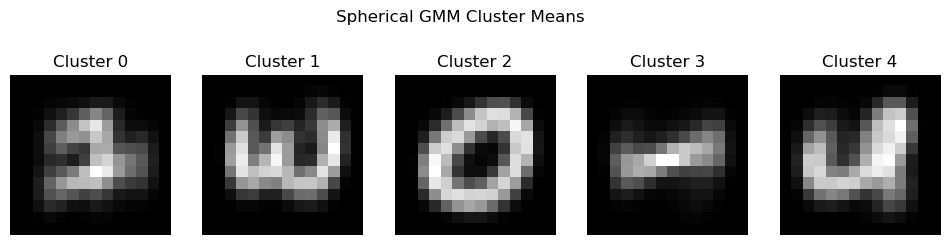

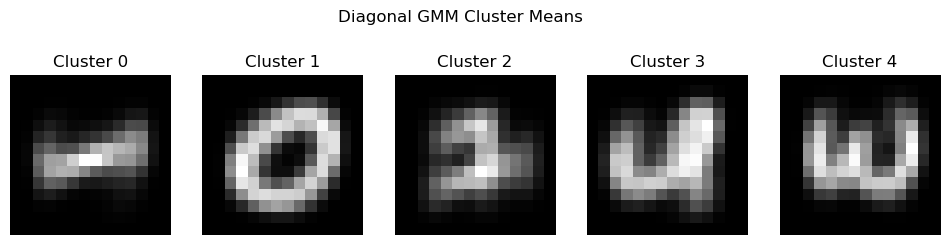

In [15]:
plot_cluster_means(mu_sph, "Spherical GMM Cluster Means")
plot_cluster_means(mu_diag, "Diagonal GMM Cluster Means")
